In [1]:
!nvidia-smi -L
!pip install pretrainedmodels

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-776b3780-cb4d-840a-c3f5-4ec1e8ef3845)


In [6]:
import torch
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
import os
from typing import Optional
from pretrainedmodels import inceptionresnetv2
import torch.nn as nn
import torch.nn.functional as F
import functools
import torchvision.transforms as transforms
from PIL import Image
import cv2
import albumentations as albu

# Model Architecture

In [9]:
class FPNHead(nn.Module):
    def __init__(self, num_in, num_mid, num_out):
        super().__init__()

        self.block0 = nn.Conv2d(num_in, num_mid, kernel_size=3, padding=1, bias=False)
        self.block1 = nn.Conv2d(num_mid, num_out, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        x = nn.functional.relu(self.block0(x), inplace=True)
        x = nn.functional.relu(self.block1(x), inplace=True)
        return x

class FPNInception(nn.Module):

    def __init__(self, norm_layer, output_ch=3, num_filters=128, num_filters_fpn=256):
        super().__init__()

        # Feature Pyramid Network (FPN) with four feature maps of resolutions
        # 1/4, 1/8, 1/16, 1/32 and `num_filters` filters for all feature maps.
        self.fpn = FPN(num_filters=num_filters_fpn, norm_layer=norm_layer)

        # The segmentation heads on top of the FPN

        self.head1 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head2 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head3 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head4 = FPNHead(num_filters_fpn, num_filters, num_filters)

        self.smooth = nn.Sequential(
            nn.Conv2d(4 * num_filters, num_filters, kernel_size=3, padding=1),
            norm_layer(num_filters),
            nn.ReLU(),
        )

        self.smooth2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, padding=1),
            norm_layer(num_filters // 2),
            nn.ReLU(),
        )

        self.final = nn.Conv2d(num_filters // 2, output_ch, kernel_size=3, padding=1)

    def unfreeze(self):
        self.fpn.unfreeze()

    def forward(self, x):
        map0, map1, map2, map3, map4 = self.fpn(x)

        map4 = nn.functional.upsample(self.head4(map4), scale_factor=8, mode="nearest")
        map3 = nn.functional.upsample(self.head3(map3), scale_factor=4, mode="nearest")
        map2 = nn.functional.upsample(self.head2(map2), scale_factor=2, mode="nearest")
        map1 = nn.functional.upsample(self.head1(map1), scale_factor=1, mode="nearest")

        smoothed = self.smooth(torch.cat([map4, map3, map2, map1], dim=1))
        smoothed = nn.functional.upsample(smoothed, scale_factor=2, mode="nearest")
        smoothed = self.smooth2(smoothed + map0)
        smoothed = nn.functional.upsample(smoothed, scale_factor=2, mode="nearest")

        final = self.final(smoothed)
        res = torch.tanh(final) + x

        return torch.clamp(res, min = -1,max = 1)

class FPN(nn.Module):

    def __init__(self, norm_layer, num_filters=256):
        """Creates an `FPN` instance for feature extraction.
        Args:
          num_filters: the number of filters in each output pyramid level
          pretrained: use ImageNet pre-trained backbone feature extractor
        """

        super().__init__()
        self.inception = inceptionresnetv2(num_classes=1000, pretrained='imagenet')

        self.enc0 = self.inception.conv2d_1a
        self.enc1 = nn.Sequential(
            self.inception.conv2d_2a,
            self.inception.conv2d_2b,
            self.inception.maxpool_3a,
        ) # 64
        self.enc2 = nn.Sequential(
            self.inception.conv2d_3b,
            self.inception.conv2d_4a,
            self.inception.maxpool_5a,
        )  # 192
        self.enc3 = nn.Sequential(
            self.inception.mixed_5b,
            self.inception.repeat,
            self.inception.mixed_6a,
        )   # 1088
        self.enc4 = nn.Sequential(
            self.inception.repeat_1,
            self.inception.mixed_7a,
        ) #2080
        self.td1 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td2 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td3 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.pad = nn.ReflectionPad2d(1)
        self.lateral4 = nn.Conv2d(2080, num_filters, kernel_size=1, bias=False)
        self.lateral3 = nn.Conv2d(1088, num_filters, kernel_size=1, bias=False)
        self.lateral2 = nn.Conv2d(192, num_filters, kernel_size=1, bias=False)
        self.lateral1 = nn.Conv2d(64, num_filters, kernel_size=1, bias=False)
        self.lateral0 = nn.Conv2d(32, num_filters // 2, kernel_size=1, bias=False)

        for param in self.inception.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.inception.parameters():
            param.requires_grad = True

    def forward(self, x):

        # Bottom-up pathway, from ResNet
        enc0 = self.enc0(x)

        enc1 = self.enc1(enc0) # 256

        enc2 = self.enc2(enc1) # 512

        enc3 = self.enc3(enc2) # 1024

        enc4 = self.enc4(enc3) # 2048

        # Lateral connections

        lateral4 = self.pad(self.lateral4(enc4))
        lateral3 = self.pad(self.lateral3(enc3))
        lateral2 = self.lateral2(enc2)
        lateral1 = self.pad(self.lateral1(enc1))
        lateral0 = self.lateral0(enc0)

        # Top-down pathway
        pad = (1, 2, 1, 2)  # pad last dim by 1 on each side
        pad1 = (0, 1, 0, 1)
        map4 = lateral4
        map3 = self.td1(lateral3 + nn.functional.upsample(map4, scale_factor=2, mode="nearest"))
        map2 = self.td2(F.pad(lateral2, pad, "reflect") + nn.functional.upsample(map3, scale_factor=2, mode="nearest"))
        map1 = self.td3(lateral1 + nn.functional.upsample(map2, scale_factor=2, mode="nearest"))
        return F.pad(lateral0, pad1, "reflect"), map1, map2, map3, map4

def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def get_generator():
    model_g = FPNInception(norm_layer=get_norm_layer(norm_type='instance'))
    return nn.DataParallel(model_g)

# Predictor

In [10]:
def get_normalize():
    normalize = albu.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    normalize = albu.Compose([normalize], additional_targets={'target': 'image'})

    def process(a, b):
        r = normalize(image=a, target=b)
        return r['image'], r['target']

    return process


class Predictor:
    def __init__(self, weights_path='/content/drive/MyDrive/sign_language/deblur_image_model/fpn_inception.h5'):
        model = get_generator()
        model.load_state_dict(torch.load(weights_path)['model'])
        self.model = model.cuda()
        self.model.train(True)
        # GAN inference should be in train mode to use actual stats in norm layers,
        # it's not a bug
        self.normalize_fn = get_normalize()

    @staticmethod
    def _array_to_batch(x):
        x = np.transpose(x, (2, 0, 1))
        x = np.expand_dims(x, 0)
        return torch.from_numpy(x)

    def _preprocess(self, x: np.ndarray, mask: Optional[np.ndarray]):
        x, _ = self.normalize_fn(x, x)
        if mask is None:
            mask = np.ones_like(x, dtype=np.float32)
        else:
            mask = np.round(mask.astype('float32') / 255)

        h, w, _ = x.shape
        block_size = 32
        min_height = (h // block_size + 1) * block_size
        min_width = (w // block_size + 1) * block_size

        pad_params = {'mode': 'constant',
                      'constant_values': 0,
                      'pad_width': ((0, min_height - h), (0, min_width - w), (0, 0))
                      }
        x = np.pad(x, **pad_params)
        mask = np.pad(mask, **pad_params)

        return map(self._array_to_batch, (x, mask)), h, w

    @staticmethod
    def _postprocess(x: torch.Tensor) -> np.ndarray:
        x, = x
        x = x.detach().cpu().float().numpy()
        x = (np.transpose(x, (1, 2, 0)) + 1) / 2.0 * 255.0
        return x.astype('uint8')

    def __call__(self, img: np.ndarray, mask: Optional[np.ndarray], ignore_mask=True) -> np.ndarray:
        (img, mask), h, w = self._preprocess(img, mask)
        with torch.no_grad():
            inputs = [img.cuda()]
            if not ignore_mask:
                inputs += [mask]
            pred = self.model(*inputs)
        return self._postprocess(pred)[:h, :w, :]

# Test

In [11]:
predictor = Predictor()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth


In [13]:
abs_path = '/content/drive/MyDrive/sign_language/data/'
path_vid = 'train/01August_2011_Monday_heute-4858.mp4'
vidcap = cv2.VideoCapture(abs_path + path_vid)

In [14]:
success,image = vidcap.read()
count = 0
images = []
while success:
  images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

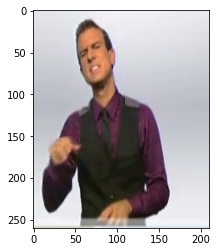

In [27]:
import matplotlib.pyplot as plt
plt.imshow(images[30])

In [28]:
pred = predictor(images[30], mask=None)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


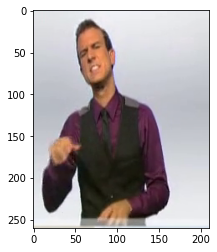

In [29]:
plt.imshow(pred)

Bof pas trop de modification ....